# Telco Customer Churn — **01_EDA_Preprocessing**
*Prepared 2025-11-04 09:25 (WIB)*  
*Author: Hans Christian*

**Goal:** Clean & explore the Telco Customer Churn data, produce a high-quality `clean` dataset ready for modeling.

---
### Checklist
- [ ] Mount Google Drive
- [ ] Load raw dataset
- [ ] Validate schema & data quality
- [ ] Handle missing/invalid values
- [ ] Fix data types (e.g., `TotalCharges`)
- [ ] Basic EDA (target distribution, numerics, categoricals)
- [ ] Save `data_clean/churn_clean.csv`


## Block 0 — Configuration & Paths
Set project paths so the notebook is **portable** across machines.


In [1]:

# If running on Google Colab, mount your Drive first:
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')
    BASE = '/content/drive/MyDrive/Portofolio/1_Telco Customer Churn'
else:
    # Local/dev fallback (edit as needed)
    BASE = '/content/drive/MyDrive/Portofolio/1_Telco Customer Churn'

RAW_DIR   = f"{BASE}/data_raw"
CLEAN_DIR = f"{BASE}/data_clean"
NOTE_DIR  = f"{BASE}/notebooks"

RAW_FILE = f"{RAW_DIR}/WA_Fn-UseC_-Telco-Customer-Churn.csv"  # rename if your filename differs
CLEAN_FILE = f"{CLEAN_DIR}/churn_clean.csv"

import os
os.makedirs(CLEAN_DIR, exist_ok=True)
print("Paths set.")
print("RAW_DIR  :", RAW_DIR)
print("CLEAN_DIR:", CLEAN_DIR)
print("RAW_FILE :", RAW_FILE)
print("CLEAN_FILE:", CLEAN_FILE)


Mounted at /content/drive
Paths set.
RAW_DIR  : /content/drive/MyDrive/Portofolio/1_Telco Customer Churn/data_raw
CLEAN_DIR: /content/drive/MyDrive/Portofolio/1_Telco Customer Churn/data_clean
RAW_FILE : /content/drive/MyDrive/Portofolio/1_Telco Customer Churn/data_raw/WA_Fn-UseC_-Telco-Customer-Churn.csv
CLEAN_FILE: /content/drive/MyDrive/Portofolio/1_Telco Customer Churn/data_clean/churn_clean.csv


## Block 1 — Imports & Utility Functions
Only standard, stable libs to avoid environment friction. Visuals use **matplotlib only** (no seaborn).


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, textwrap

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

def percent(n, d):
    return 0 if d == 0 else 100.0 * n / d

def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:
    total = df.shape[0]
    miss = df.isna().sum()
    miss_pct = (miss / total * 100).round(2)
    out = pd.DataFrame({"missing_count": miss, "missing_pct": miss_pct})
    out = out[out["missing_count"] > 0].sort_values("missing_pct", ascending=False)
    return out

def bar_text(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.0f}", (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom', xytext=(0,3), textcoords='offset points')


## Block 2 — Load Dataset


In [3]:

# Read CSV (Kaggle Telco Churn)
df = pd.read_csv(RAW_FILE)
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Block 3 — Quick Peek & Schema Validation


In [4]:

print("Columns:", list(df.columns))
print("\nInfo:")
df.info()
print("\nTarget value counts:")
if "Churn" in df.columns:
    print(df["Churn"].value_counts(dropna=False))
else:
    raise ValueError("Column 'Churn' not found. Please check RAW_FILE name or dataset columns.")


Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null

## Block 4 — Data Quality Checks
- Duplicates, whitespace-only strings, special `TotalCharges` issues, and basic integrity rules.


In [5]:

# 4.1 Duplicates by customerID
if "customerID" in df.columns:
    dup = df.duplicated(subset=["customerID"]).sum()
    print("Duplicate customerID:", dup)
else:
    print("Warning: 'customerID' column not found.")

# 4.2 Trim whitespace in string columns
str_cols = df.select_dtypes(include="object").columns.tolist()
for c in str_cols:
    df[c] = df[c].astype(str).str.strip()

# 4.3 Blank-as-NaN
df.replace({"": np.nan, " ": np.nan}, inplace=True)

# 4.4 TotalCharges numeric fix
if "TotalCharges" in df.columns:
    before_na = df["TotalCharges"].isna().sum()
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    after_na = df["TotalCharges"].isna().sum()
    print(f"TotalCharges coerced to numeric. NA before={before_na}, after={after_na}")
else:
    print("Warning: 'TotalCharges' not found.")

# 4.5 Missing summary
miss = summarize_missing(df)
miss


Duplicate customerID: 0
TotalCharges coerced to numeric. NA before=11, after=11


,missing_count,missing_pct
TotalCharges,11,0.16


## Block 5 — Minimal Imputation Strategy
- Business-safe defaults for EDA stage; advanced imputations can be done in modeling pipeline.


In [6]:

# Example: fill NA in TotalCharges with MonthlyCharges * tenure (approx), else 0
if set(["TotalCharges", "MonthlyCharges", "tenure"]).issubset(df.columns):
    mask = df["TotalCharges"].isna()
    approx = df["MonthlyCharges"] * df["tenure"]
    df.loc[mask, "TotalCharges"] = approx[mask].fillna(0)
    print("Filled NA in TotalCharges with MonthlyCharges*tenure where available.")
else:
    print("Skipping TotalCharges fill: columns not complete.")

# For any remaining object NA in binary-like fields, fill with 'Unknown' for EDA
for c in df.select_dtypes(include="object"):
    df[c] = df[c].fillna("Unknown")

# For numerics, simple fill for EDA visualization
for c in df.select_dtypes(include=[np.number]):
    df[c] = df[c].fillna(df[c].median())


Filled NA in TotalCharges with MonthlyCharges*tenure where available.


## Block 6 — Target Distribution & Baseline


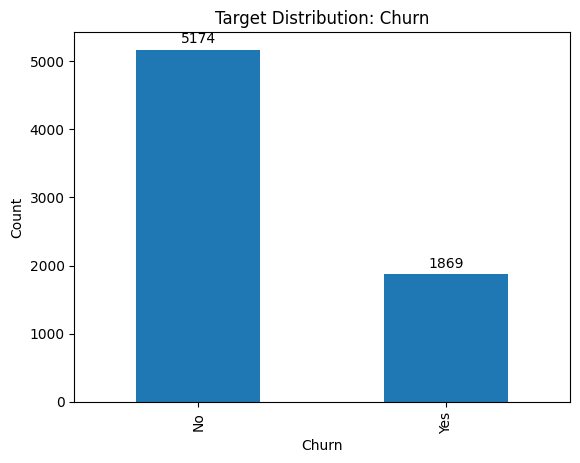

Baseline accuracy (majority class): 0.735


In [7]:

if "Churn" in df.columns:
    vc = df["Churn"].value_counts()
    ax = vc.plot(kind="bar")
    ax.set_title("Target Distribution: Churn")
    ax.set_xlabel("Churn")
    ax.set_ylabel("Count")
    bar_text(ax)
    plt.show()

    baseline = vc.max() / vc.sum()
    print(f"Baseline accuracy (majority class): {baseline:.3f}")
else:
    print("Target 'Churn' missing.")


## Block 7 — Numerical EDA (Histograms)


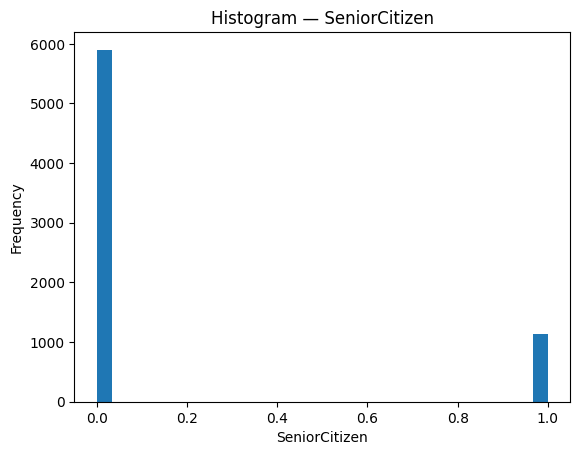

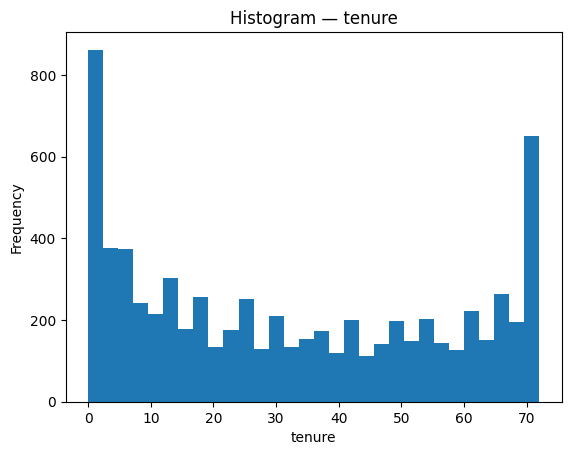

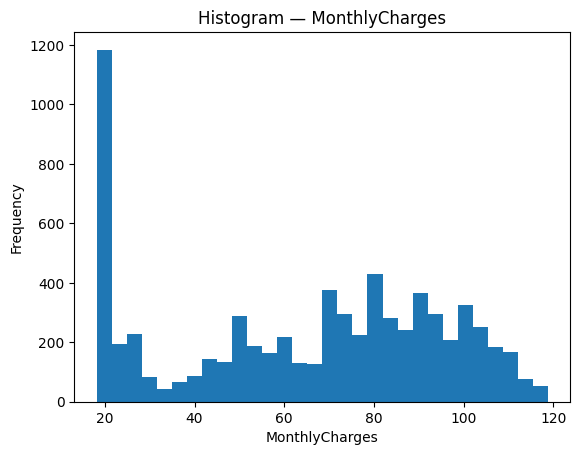

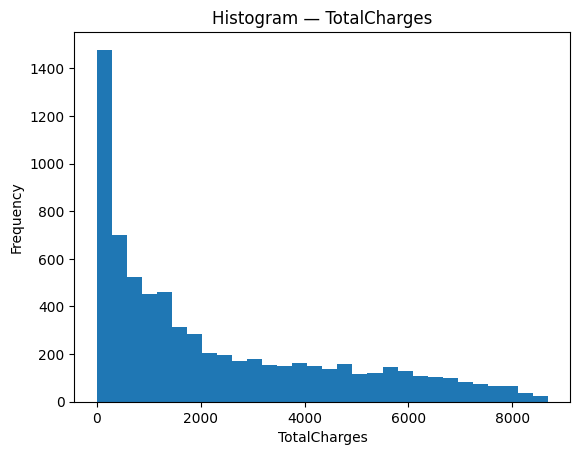

In [8]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    df[c].plot(kind="hist", bins=30, title=f"Histogram — {c}")
    plt.xlabel(c); plt.ylabel("Frequency")
    plt.show()


## Block 8 — Categorical EDA (Bar Charts)


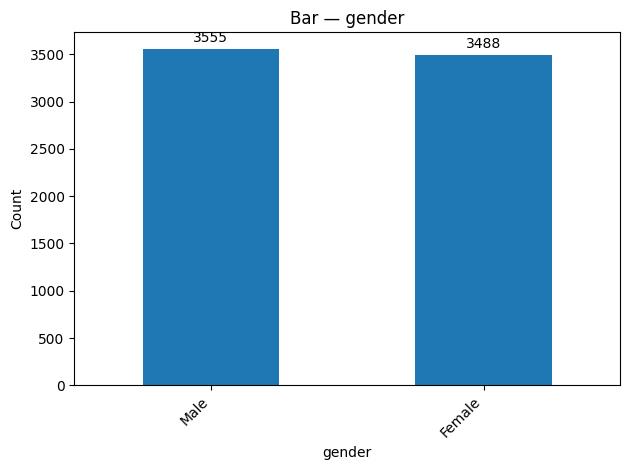

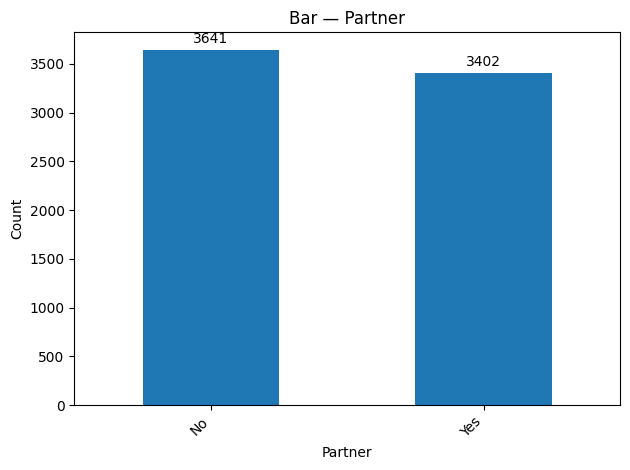

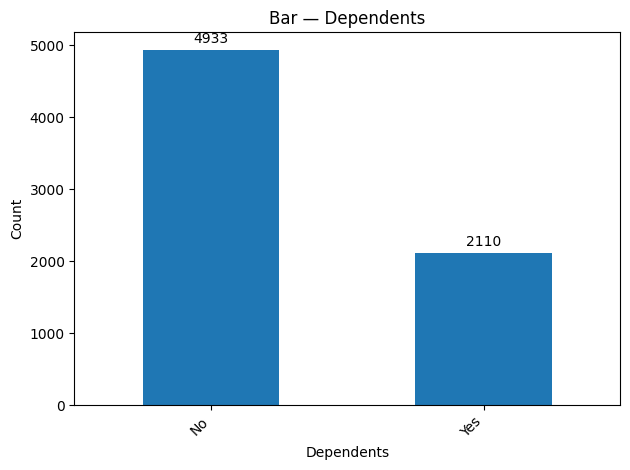

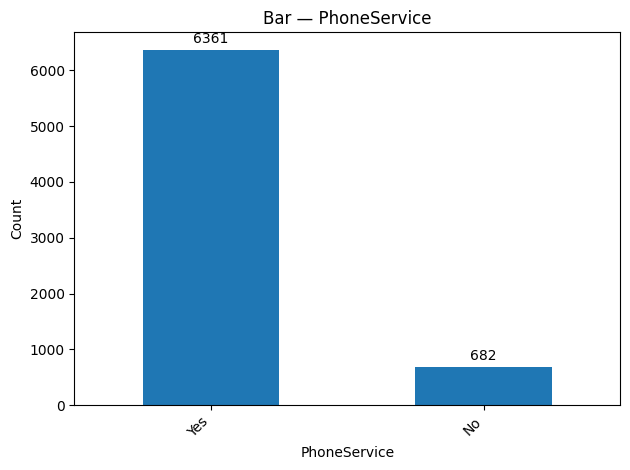

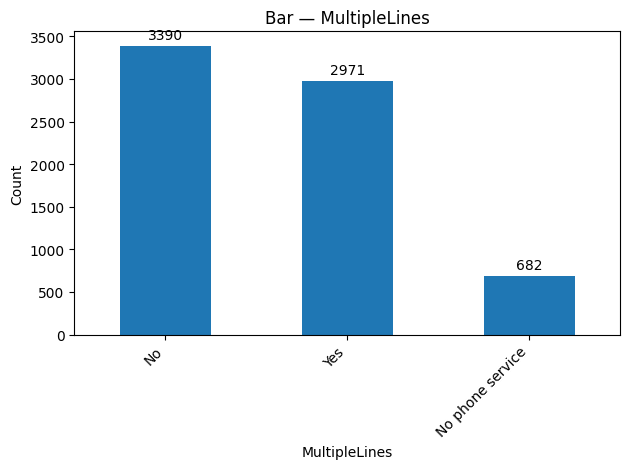

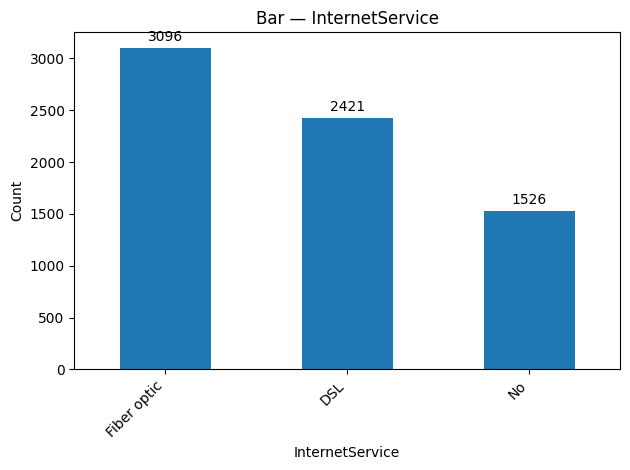

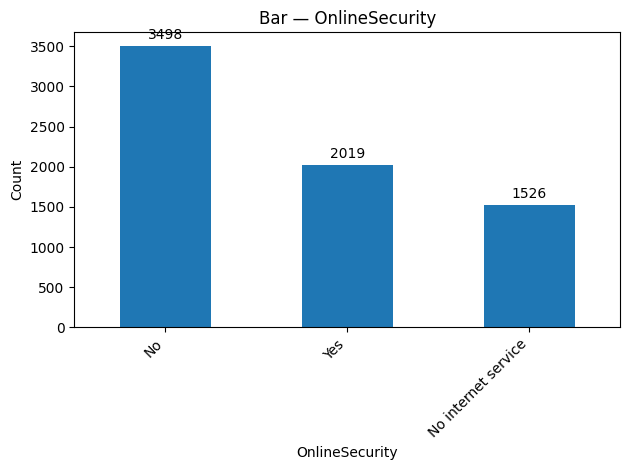

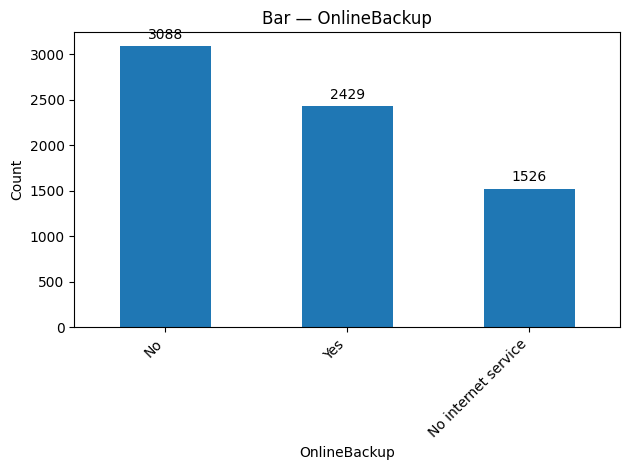

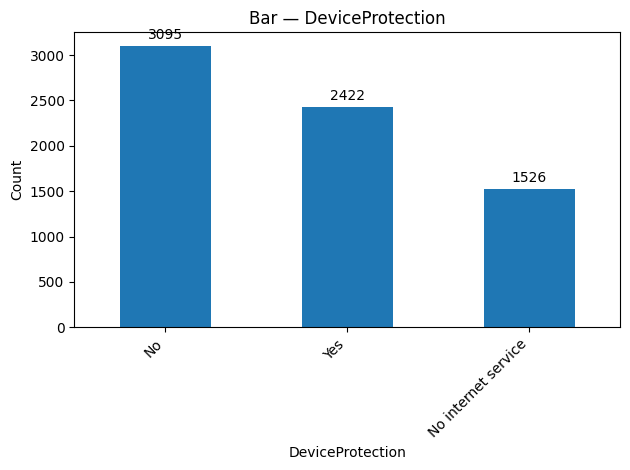

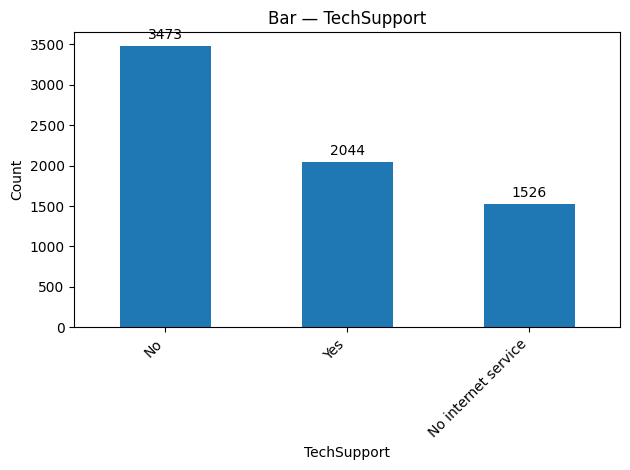

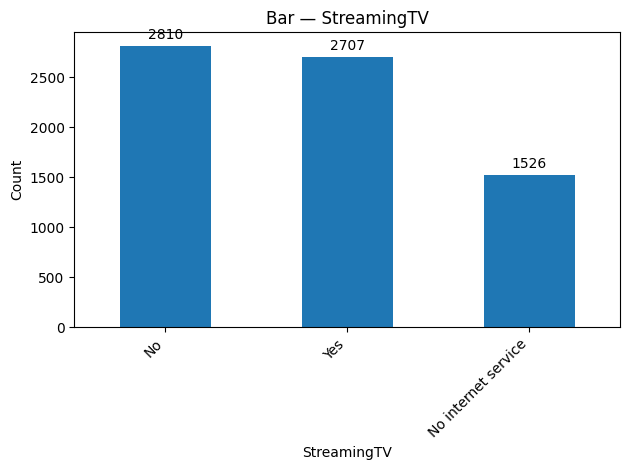

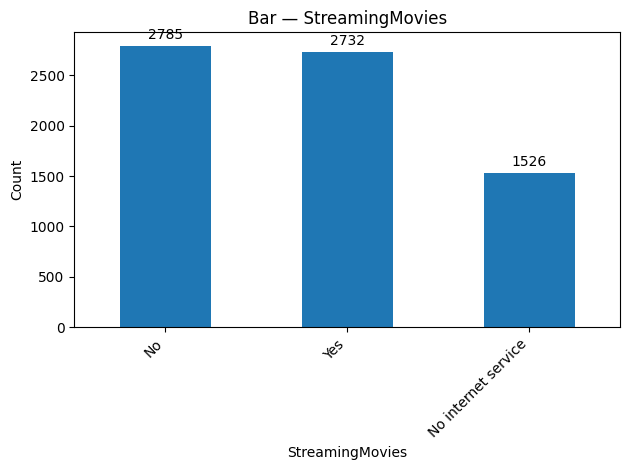

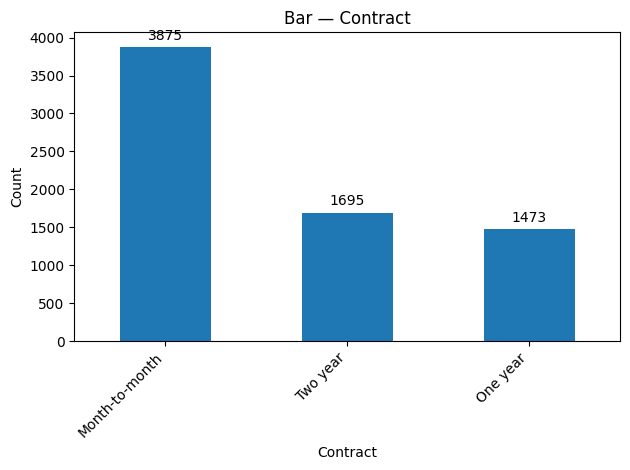

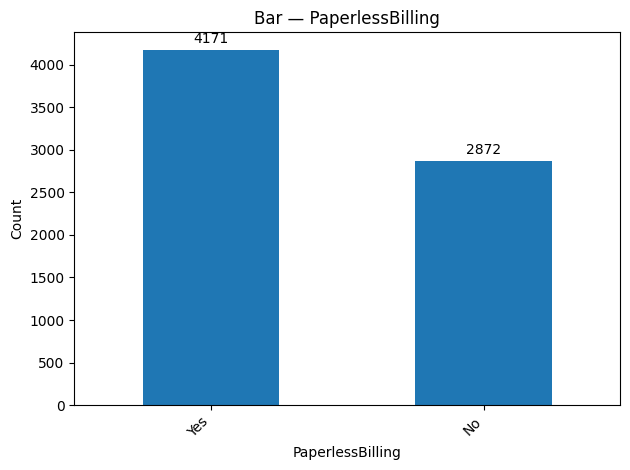

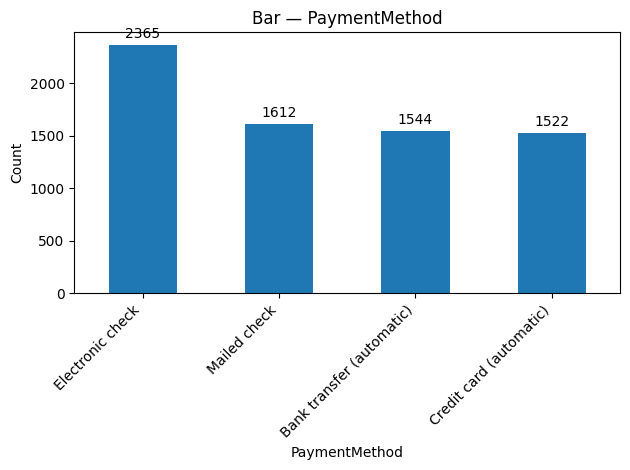

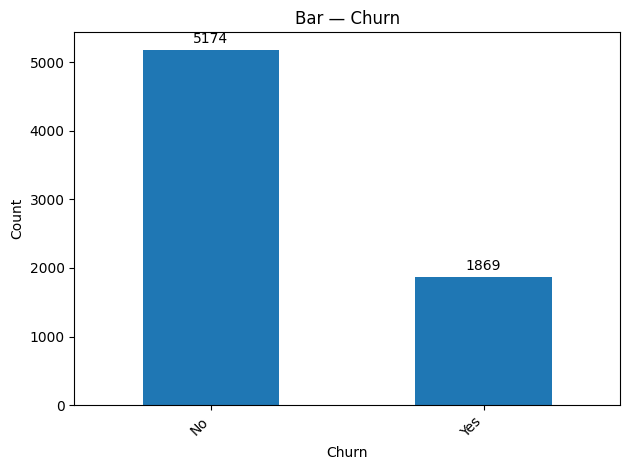

In [9]:

cat_cols = df.select_dtypes(include="object").columns.tolist()
# Exclude high-cardinality identifiers from charting
cat_cols = [c for c in cat_cols if c.lower() not in ["customerid"]]

for c in cat_cols:
    vc = df[c].value_counts().sort_values(ascending=False).head(30)
    ax = vc.plot(kind="bar")
    ax.set_title(f"Bar — {c}")
    ax.set_xlabel(c); ax.set_ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    bar_text(ax)
    plt.tight_layout()
    plt.show()


## Block 9 — Relationship Checks (Target vs Features)


In [10]:

# Numeric vs Target: box-like overview (describe by churn group)
if "Churn" in df.columns:
    for c in num_cols:
        grp = df.groupby("Churn")[c].describe().T
        print(f"\n=== {c} by Churn ===")
        display(grp)

# Categorical vs Target: cross-tab
if "Churn" in df.columns:
    for c in cat_cols:
        ct = pd.crosstab(df[c], df["Churn"], dropna=False)
        ct["row_pct_yes"] = (ct["Yes"] / ct.sum(axis=1) * 100) if "Yes" in ct.columns else np.nan
        print(f"\n=== {c} vs Churn ===")
        display(ct.sort_values(by=ct.columns.tolist(), ascending=False).head(20))



=== SeniorCitizen by Churn ===


Churn,No,Yes
count,5174.000000,1869.000000
mean,0.128721,0.254682
std,0.334923,0.435799
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,1.000000
max,1.000000,1.000000



=== tenure by Churn ===


Churn,No,Yes
count,5174.000000,1869.000000
mean,37.569965,17.979133
std,24.113777,19.531123
min,0.000000,1.000000
25%,15.000000,2.000000
50%,38.000000,10.000000
75%,61.000000,29.000000
max,72.000000,72.000000



=== MonthlyCharges by Churn ===


Churn,No,Yes
count,5174.000000,1869.000000
mean,61.265124,74.441332
std,31.092648,24.666053
min,18.250000,18.850000
25%,25.100000,56.150000
50%,64.425000,79.650000
75%,88.400000,94.200000
max,118.750000,118.350000



=== TotalCharges by Churn ===


Churn,No,Yes
count,5174.000000,1869.000000
mean,2549.911442,1531.796094
std,2329.954215,1890.822994
min,0.000000,18.850000
25%,572.900000,134.500000
50%,1679.525000,703.550000
75%,4262.850000,2331.300000
max,8672.450000,8684.800000



=== gender vs Churn ===


Churn,No,Yes,row_pct_yes
gender,,,
Male,2625,930,26.160338
Female,2549,939,26.920872



=== Partner vs Churn ===


Churn,No,Yes,row_pct_yes
Partner,,,
Yes,2733,669,19.664903
No,2441,1200,32.957979



=== Dependents vs Churn ===


Churn,No,Yes,row_pct_yes
Dependents,,,
No,3390,1543,31.279140
Yes,1784,326,15.450237



=== PhoneService vs Churn ===


Churn,No,Yes,row_pct_yes
PhoneService,,,
Yes,4662,1699,26.709637
No,512,170,24.926686



=== MultipleLines vs Churn ===


Churn,No,Yes,row_pct_yes
MultipleLines,,,
No,2541,849,25.044248
Yes,2121,850,28.609896
No phone service,512,170,24.926686



=== InternetService vs Churn ===


Churn,No,Yes,row_pct_yes
InternetService,,,
DSL,1962,459,18.959108
Fiber optic,1799,1297,41.892765
No,1413,113,7.404980



=== OnlineSecurity vs Churn ===


Churn,No,Yes,row_pct_yes
OnlineSecurity,,,
No,2037,1461,41.766724
Yes,1724,295,14.611194
No internet service,1413,113,7.404980



=== OnlineBackup vs Churn ===


Churn,No,Yes,row_pct_yes
OnlineBackup,,,
Yes,1906,523,21.531494
No,1855,1233,39.928756
No internet service,1413,113,7.404980



=== DeviceProtection vs Churn ===


Churn,No,Yes,row_pct_yes
DeviceProtection,,,
No,1884,1211,39.127625
Yes,1877,545,22.502064
No internet service,1413,113,7.404980



=== TechSupport vs Churn ===


Churn,No,Yes,row_pct_yes
TechSupport,,,
No,2027,1446,41.635474
Yes,1734,310,15.166341
No internet service,1413,113,7.404980



=== StreamingTV vs Churn ===


Churn,No,Yes,row_pct_yes
StreamingTV,,,
Yes,1893,814,30.070188
No,1868,942,33.523132
No internet service,1413,113,7.404980



=== StreamingMovies vs Churn ===


Churn,No,Yes,row_pct_yes
StreamingMovies,,,
Yes,1914,818,29.941435
No,1847,938,33.680431
No internet service,1413,113,7.404980



=== Contract vs Churn ===


Churn,No,Yes,row_pct_yes
Contract,,,
Month-to-month,2220,1655,42.709677
Two year,1647,48,2.831858
One year,1307,166,11.269518



=== PaperlessBilling vs Churn ===


Churn,No,Yes,row_pct_yes
PaperlessBilling,,,
Yes,2771,1400,33.565092
No,2403,469,16.330084



=== PaymentMethod vs Churn ===


Churn,No,Yes,row_pct_yes
PaymentMethod,,,
Mailed check,1304,308,19.106700
Electronic check,1294,1071,45.285412
Credit card (automatic),1290,232,15.243101
Bank transfer (automatic),1286,258,16.709845



=== Churn vs Churn ===


Churn,No,Yes,row_pct_yes
Churn,,,
No,5174,0,0.0
Yes,0,1869,100.0


## Block 10 — Export Clean Dataset


In [11]:

df.to_csv(CLEAN_FILE, index=False)
print("Saved:", CLEAN_FILE, "— rows:", len(df))


Saved: /content/drive/MyDrive/Portofolio/1_Telco Customer Churn/data_clean/churn_clean.csv — rows: 7043


## 🧭 Next Steps
Lanjut ke notebook **02_Modeling_Interpretation.ipynb**:
- Train/test split, encoding & scaling
- Baseline models (LogReg)
- Gradient boosting (XGBoost/LightGBM)
- Class imbalance (SMOTE)
- Explainability (SHAP)
- Business interpretation + what-if recommendations
